In [30]:
from __future__ import division
import numpy as np
import scipy.fftpack as sf
import matplotlib.pyplot as plt
import pylab as pl
import scipy.signal as sig
from scipy import misc

## 1. STFT  (Short Time Fourier Transform) and source separation.

## In this part, we use STFT which is a collection of Fourier transform of a 1D signal on time subintervals. Why using STFT ?
- The length of a music signal for 4 minutes sampled at a rate of 44kHz is roughly $2500*44000 \simeq 1.1 \times 10^7$.
- The length of a music note is of the order of a tenth of a second.
### Conclusion: do not use FFT on the whole signal but on short segments of it.

### We use it in order to experiment source separation which comes from the idea that the different signals may present very different behaviour in the frequency domain.

In [31]:
# utils to load the sounds.
import numpy as np
import wave as wv

def load_sound(file, n0):
    
    x_raw = wv.open(file)
    n = x_raw.getnframes()
    x = np.frombuffer(x_raw.readframes(-1), dtype=np.int16)
    x_raw.close()
    
    if file[::-1][:8][::-1] == "bird.wav":
        x = np.delete(x,list(range(6001)) + list(range(12500, 15001)) + list(range(22500, 24001)) + list(range(32500,34001)))

    if n0 !=0 and n0 < n:
        x = x[:n0]
    
    return x/np.max(x)

## Hereafter, we load the $3$ sounds and plot the second one.

In [32]:
n = 1024*16
s = 3 #number of signals.
x = np.zeros([n,3])
x[:,0] = load_sound("bird.wav",n)
x[:,1] = load_sound("female.wav",n)
x[:,2] = load_sound("male.wav",n)

## listen to a sound.
from IPython.display import Audio
Audio(x[:,1], rate = 15000)

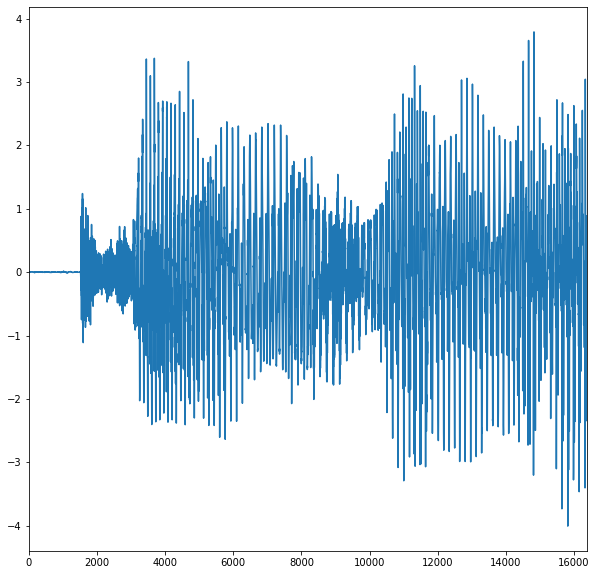

In [33]:
# Show the numerical signal.
x = x/np.tile(np.std(x,0),(n,1))
p = 2 #number of micros
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.xlim(0,n)
plt.plot(x[:,2])
plt.show()

### We simulate two micros which are implemented by linear combinations of the signals.

In [34]:
theta = np.linspace(0, np.pi, s + 1)[:-1]
theta[0] = .2
M = np.vstack((np.cos(theta), np.sin(theta)))
## recorded signals
y = np.dot(x,np.transpose(M))
print("length of the signals",np.shape(y))
# Listen to the two recorded signals.
from IPython.display import Audio
Audio(y[:,1], rate = 15000)

length of the signals (16384, 2)


### We use the STFT function from the python package signal and plot it.

16641


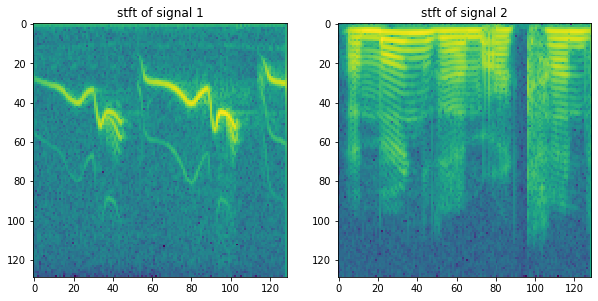

In [35]:
import scipy.signal as sig
f,t,w = sig.stft(x[:,0])
a,b,z = sig.stft(x[:,1])
print(np.size(z))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title("stft of signal 1")
plt.imshow(np.log(np.abs(w)))
plt.subplot(1,2,2)
plt.title("stft of signal 2")
plt.imshow(np.log(np.abs(z)))

### We numerically check that the STFT and ISTFT are indeed inverse from each others.

In [36]:
micro1 = y[:,0]
micro2 = y[:,1]
stft = lambda im : sig.stft(im,noverlap = 64,nperseg = 128)
istft = lambda im : sig.istft(im,noverlap = 64,nperseg = 128)
f,t,w1 = stft(micro1)
print(np.shape(w1))
f,t,w2 = stft(micro2)
W = np.asarray([w1.flatten(),w2.flatten()])
print(np.shape(W))
t,recov = istft(w1)
print(np.sum((micro1 - recov)**2))

(65, 257)
(2, 16705)
1.0101480981032716e-27


### By selecting randomly a group of points in time, we plot in the plane the coordinates of the points, being the measured signals by the micros.

16384


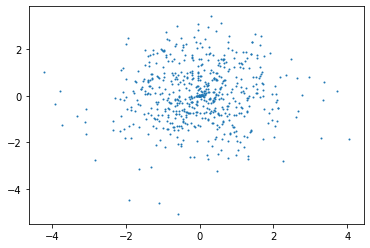

In [37]:
nbre_selec = 600
from random import shuffle
print(np.shape(y)[0])

def getRandomValuesFromSignal(s, n = 600):
    randomIds = np.arange(s.shape[0])
    shuffle(randomIds)
    return s[randomIds[:n]]

yValues = getRandomValuesFromSignal(y, nbre_selec)
plt.plot(yValues[:,0],yValues[:,1],"o",markersize=1)
plt.show()

### Q: Do the same with the STFT signals, what do you observe ?

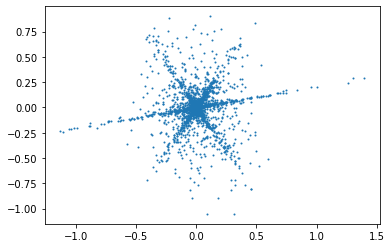

[[-0.00033262 -0.0002668 ]
 [-0.01664807 -0.02739785]
 [-0.00656574  0.01582504]
 ...
 [ 0.01462426  0.02846472]
 [ 0.06398988  0.06937785]
 [ 0.0202205  -0.03161194]]


In [38]:
signal = W.real.transpose()

stftValues = getRandomValuesFromSignal(signal, 10000)
plt.plot(stftValues[:,0],stftValues[:,1],"o",markersize=1)
plt.show()

print(stftValues)


### Q: For each point in the plot above, compute its angle and plot the distribution of the angles (use the function np.histogram) and plot it.

[0.67602597 1.02477703 1.9640774  ... 1.09619513 0.82577558 2.13985938]


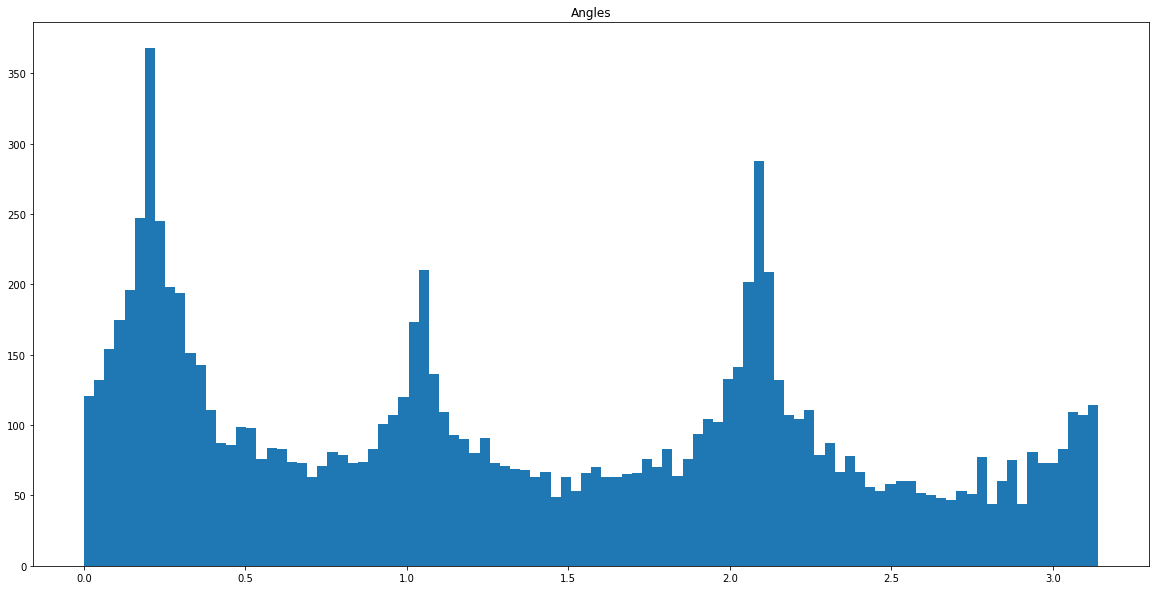

In [39]:
angles = np.array([np.arctan2(p[1],p[0]) for p in stftValues]) % np.pi
print(angles)

resolution = 100
plt.figure(figsize=(20,10))
plt.title("Angles")
plt.hist(angles, bins=resolution)
plt.show()

### Q: By selecting the highest peaks of the distribution, estimate the angles of the mixing.

In [40]:
peakCounts, peakBins = np.histogram(angles, bins=resolution)
peaks, prop = sig.find_peaks(peakCounts, distance=10)

maxPeakIdx = peakCounts[peaks].argsort()[-3:]

peakAngles = peakBins[peaks][maxPeakIdx]
print("Angles : ", peakAngles)

Angles :  [1.03670103 2.07338955 0.18850133]


### Q: Using the STFT recorded signals, take each point in the plane and compute its projection on each recovered directions. It gives a vector of 3 estimated projections.

[[[ 4.00661119e-03  6.77442995e-03]
  [ 1.73464466e-03 -3.15576741e-03]
  [ 1.16253639e-02  2.21772626e-03]]

 [[ 6.91605385e-03  1.16937532e-02]
  [ 1.11092792e-03 -2.02106530e-03]
  [ 1.67203454e-02  3.18967640e-03]]

 [[ 6.69934129e-03  1.13273328e-02]
  [ 2.45750188e-03 -4.47083171e-03]
  [ 1.86512782e-02  3.55803308e-03]]

 ...

 [[ 1.37816553e-05  2.33022008e-05]
  [ 4.37483314e-05 -7.95895331e-05]
  [ 1.07129864e-04  2.04367549e-05]]

 [[ 2.89799012e-04  4.89995913e-04]
  [ 8.98502563e-05 -1.63460862e-04]
  [ 7.77570044e-04  1.48334067e-04]]

 [[ 2.21735639e-03  3.74913483e-03]
  [ 2.58038157e-04 -4.69438166e-04]
  [ 5.18631232e-03  9.89372987e-04]]]


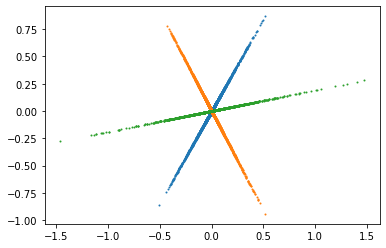

In [41]:

# Compute directions of peak angles
directions = np.array([[np.cos(angle), np.sin(angle)] for angle in peakAngles])

projections = np.array([[np.dot(pt, d)*d for d in directions] for pt in signal])
print(projections)

plt.plot(projections[:,:, 0],projections[:,:,1],"o",markersize=1)
plt.show()


### Q: For each frequency point in the signal STFT, select the direction on which it has the largest projection. And threshold using the code below.

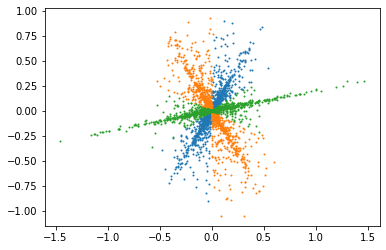

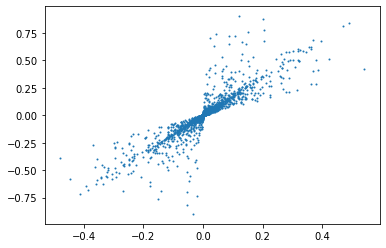

[[ 5.33292706e-02  6.97964654e-02]
 [ 4.74272504e-02  4.39447763e-02]
 [-3.70480758e-03 -2.66895909e-02]
 ...
 [ 3.34077404e-05  1.14457263e-04]
 [ 6.64382555e-07  3.60863548e-05]
 [-3.48139083e-04 -2.50901585e-04]]
64


In [42]:

projectionsAbs = np.array([[np.abs(np.dot(pt, d)) for d in directions] for pt in signal])
#print(projectionsAbs)
bestProjectionIndex = np.argmax(projectionsAbs, axis=1)
#print(bestProjectionIndex)

largestProj = [[], [], []]
for idx, pt in zip(bestProjectionIndex, signal):
    largestProj[idx].append(pt)

largestProj = [np.array(a) for a in largestProj] # convert to numpy array

for i in range(len(largestProj)):
    plt.plot(largestProj[i][:, 0],largestProj[i][:, 1],"o",markersize=1)

plt.show()

plt.plot(largestProj[0][:,0], largestProj[0][:,1],"o",markersize=1)
plt.show()

print(largestProj[0])

recoveredSignal = np.array(istft(largestProj[0]))
print(len(recoveredSignal[1]))

#threshold = .005
#D = np.sqrt(np.sum(W**2, 0))
#I = I*(D > threshold)

### Q: Plot the STFT and the time domain of the recovered signals and the original signals. Estimate the performance using the SNR implemented below.

In [43]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

### Q: Listen to the reconstructed signals and the original signals.

In [44]:
i = 0
from IPython.display import Audio

splitted = np.array([(np.where(bestProjectionIndex == i, 1, 0) * signal.T).T for i in range(3)])

t, data = istft(splitted[0][:,0].reshape(65, 257))
print(len(data))

Audio(data, rate = 15000)

16384


In [45]:
i = 0
from IPython.display import Audio
#Audio(x[:,i], rate = 15000)

# 2. The goal of this part is to explore implementations of a FIR or an IIR.

## We plot below a signal with a mix of low and high frequencies.

(1000,) (1000,)


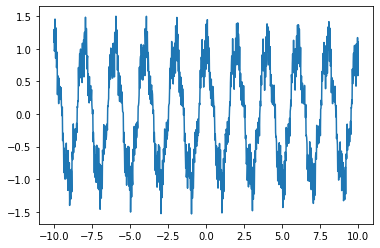

In [46]:
f = lambda t: np.cos(np.pi*t) + 0.2*np.sin(5*np.pi*t+0.1) + 0.2*np.sin(30*np.pi*t)  + 0.1*np.sin(32*np.pi*t+0.1) + 0.1*np.sin(47* np.pi*t+0.8)
t=np.linspace(-10,10,1000); 
signal=f(t)
print(np.shape(t),np.shape(signal))
plt.plot(t, signal)

## Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument and apply it to the signal above by convolution or using FFT.


C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


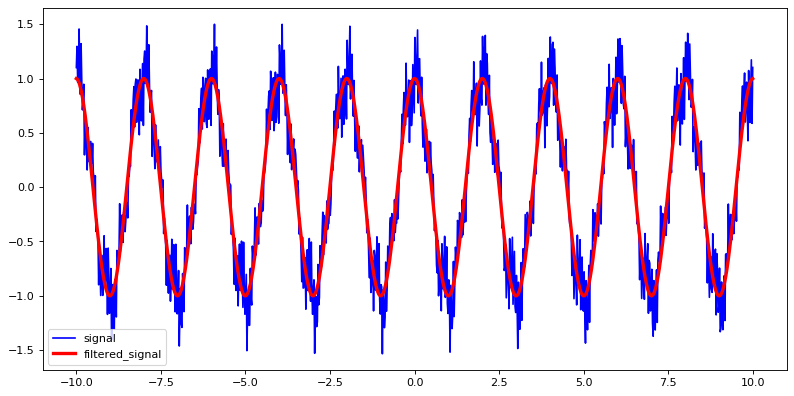

In [47]:
import scipy as sp 

def filterSignal(signal, filter, fc):
  return sp.fft.ifft(filter(sp.fft.fft(signal), fc))

LPFilter = lambda fftSignal, fc: np.array([f if np.abs(f) > fc else 0 for f in fftSignal])
filtered_signal = filterSignal(signal, LPFilter, 100)

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(t, signal, 'b', label="signal")
plt.plot(t, filtered_signal, 'r', label="filtered_signal", linewidth=3)
plt.legend()
plt.show()

## Q2. Using the code below, implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 
### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

In [48]:
def myIIR(x,a,b):
    ### a is the numerator
    ### b is the denominator
    assert(len(a)==len(b)),"a,b must have the same length"
    y = np.zeros_like(x)
    k = len(a)
    for i in range(len(a),len(x)):
        y[i] = np.sum(np.flipud(b)*y[i-k:i]) + np.sum(np.flipud(a) * x[i-k+1:i+1])
    return y

## In the following, we are given an electrocardiogram. We plot it as a function of time.

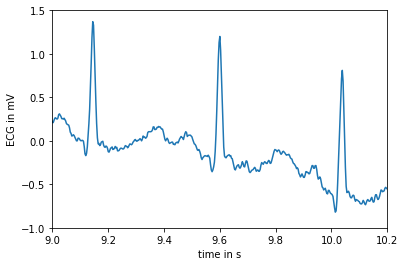

time min 0.0
time max 299.9972222222222


In [49]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])



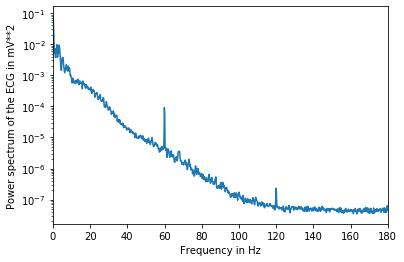

In [50]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sig.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

## Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.